# File and libraries

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


#filepath=r'dataset/df_ecom_2_2_mv_input'
filepath=r'dataset/df_ecom_2_3_outliers_input'

#filepath=r'dataset/df_ecom_2_5_feat_eng_input'
#filepath=r'dataset/df_ecom_2_5_feat_eng_input_v2'

test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [52]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [53]:
%run "data_functions.py"


data_functions loaded


# Load

In [54]:

test_data=False
# test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.05
    df = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    
    
else:
    df=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)



 
target='is_purchase'
target_metric_2='precision'
target_metric='f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235411 entries, 0 to 235410
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  235411 non-null  float64
 1   category_code_lvl_2  235411 non-null  float64
 2   price                235411 non-null  float64
 3   is_purchase          235411 non-null  int64  
 4   activity_in_session  235411 non-null  float64
 5   week_of_month        235411 non-null  int64  
 6   is_weekend           235411 non-null  int64  
 7   day                  235411 non-null  int64  
 8   brand_value          235411 non-null  float64
 9   product_category     235411 non-null  int64  
 10  time_of_day_sin      235411 non-null  float64
 11  time_of_day_cos      235411 non-null  float64
 12  day_of_week_sin      235411 non-null  float64
 13  day_of_week_cos      235411 non-null  float64
 14  hour_sin             235411 non-null  float64
 15  hour_cos             2

# Balancing Analysis

Minority class= 1 : 38111
Majority class= 0 : 197300
Original class distribution:
is_purchase
0    83.810867
1    16.189133
Name: proportion, dtype: float64



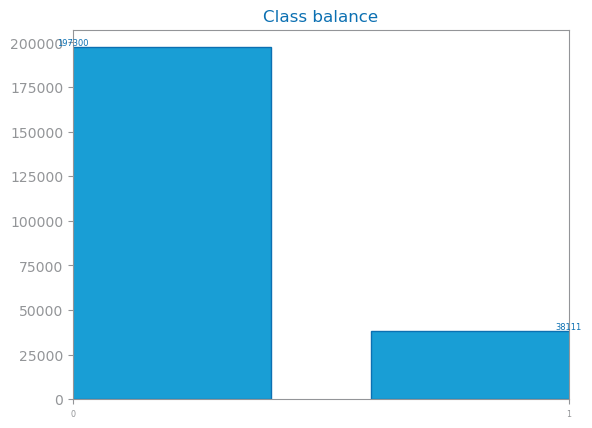

In [55]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = df[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

print(f"Original class distribution:\n{df[target].value_counts(normalize=True) * 100}\n")


figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

# Balance 1 - Undersampling

## Bal 1 strategy Application

In [56]:

def apply_balanced_downsampling(df: DataFrame,target='is_purchase') -> DataFrame:

    df_copy=df.copy()


    # Ensure positive_class and negative_class are defined and match the target values
    positive_class = 1  # Or whatever your positive class value is
    negative_class = 0  # Or whatever your negative class value is

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Downsample the majority class to match the size of the minority class
    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

    # Combine the downsampled majority class with the minority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # sort  the combined dataset
    df_balanced.sort_values(by='day', inplace=True)
    

    # Check the new class distribution to verify the balance
    print(f"Balanced class distribution:\n{df_balanced[target].value_counts(normalize=True) * 100}\n")

    
    return df_balanced


def apply_balanced_hybrid(df, target, minority_ratio=0.5):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Define positive and negative classes
    positive_class = 1  # Modify as per your positive class value
    negative_class = 0  # Modify as per your negative class value

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the current class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Sort by 'day_of_year' (or another time-related feature) to ensure the data is split based on time
    df_majority.sort_values(by='day', inplace=True)
    df_minority.sort_values(by='day', inplace=True)

    # Determine the desired size for the final dataset
    total_majority_samples = len(df_majority)
    # total_minority_samples = len(df_minority)
    
    # Set the ratio for the majority and minority classes
    desired_minority_ratio = minority_ratio
    desired_majority_ratio = 1-minority_ratio


    # Calculate the new majority size (XX% of the total number of majority samples)
    downsampled_majority_size = int(desired_majority_ratio * total_majority_samples)

    # Calculate the corresponding upsampled minority size (XX% of the downsampled majority size)
    upsampled_minority_size = int(downsampled_majority_size * (desired_minority_ratio / desired_majority_ratio))
    
    # Downsample the majority class (keeping the older data based on 'day_of_year')
    df_majority_downsampled = df_majority.head(downsampled_majority_size)

    # Upsample the minority class to match the desired minority size for a XX/XX split
    df_minority_upsampled = df_minority.sample(n=upsampled_minority_size, replace=True)

    # Combine the downsampled majority and upsampled minority classes
    df_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])

    # Sort the dataset by 'day_of_year' again if needed
    df_balanced.sort_values(by='day', inplace=True)

    # Check the new class distribution
    print(f"Hybrid class distribution ({desired_majority_ratio*100}/{desired_minority_ratio*100}):\n{df_balanced[target].value_counts(normalize=True) * 100}\n")

    return df_balanced



def apply_balanced_smote(df,target='is_purchase'):

    from imblearn.over_sampling import SMOTE

    # Create a copy of the dataframe
    df_copy = df.copy()

    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")


    # Separate the features (X) and the target (y)
    X = df_copy.drop(columns=[target])
    y = df_copy[target]

    # Apply SMOTE to balance the data
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # Recombine the features and target into a single dataframe
    df_smote = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=[target])], axis=1)

    # Sort the dataset by 'day_of_year' again if needed
    df_smote.sort_values(by='day', inplace=True)

    print(f"New class distribution:\n{df_smote[target].value_counts(normalize=True) * 100}\n")


    return df_smote

print("data_functions lodaded")




data_functions lodaded


In [57]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler


def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    df_balanced=apply_balanced_downsampling(df_copy)
    
    return df_balanced


train_1=apply_strategy_1(train)
test_1=test.copy()


Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

Balanced class distribution:
is_purchase
1    50.0
0    50.0
Name: proportion, dtype: float64



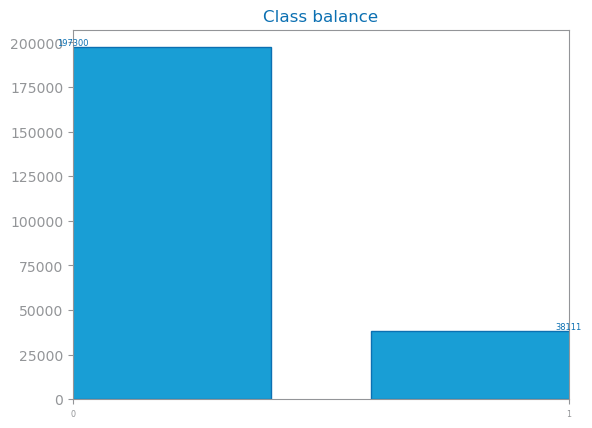

In [58]:
figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

## Bal 1 train/test split 

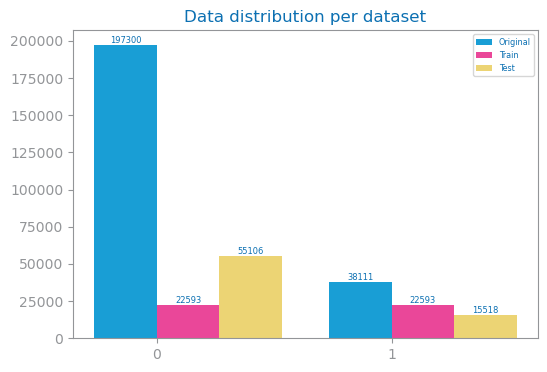

In [59]:
if evaluate==True:
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(df[df[target] == 0]),  # Assuming 0 is the negative class
            len(df[df[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 1 evaluate

#### eval target_metric_2 - precision

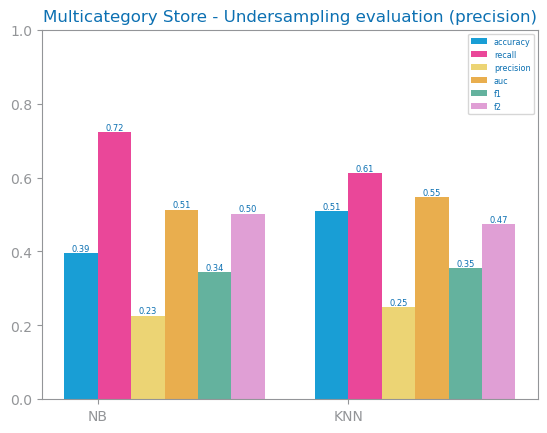

In [60]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

if evaluate==True:
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric=target_metric_2)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag} - Undersampling evaluation ({target_metric_2})", percentage=True
    )
    savefig(f"images/{file_tag}_balancing_approach_1_eval_{target_metric_2}.png")
    show()

#### eval target_metric - f2

In [61]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler


def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    df_balanced=apply_balanced_downsampling(df_copy)
    
    return df_balanced


train_1=apply_strategy_1(train)
test_1=test.copy()


Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

Balanced class distribution:
is_purchase
1    50.0
0    50.0
Name: proportion, dtype: float64



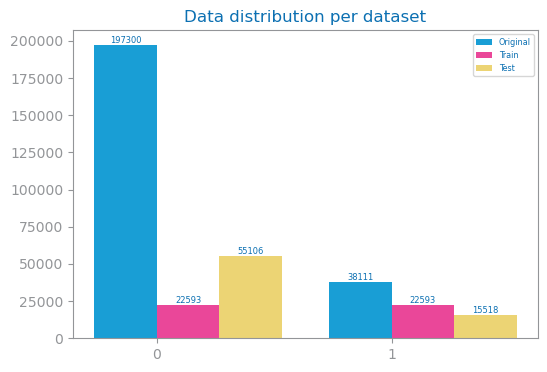

In [62]:
if evaluate==True:
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(df[df[target] == 0]),  # Assuming 0 is the negative class
            len(df[df[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

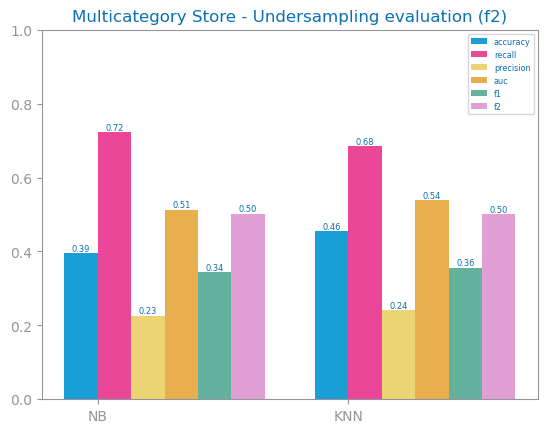

In [63]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

if evaluate==True:
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag} - Undersampling evaluation ({target_metric})", percentage=True
    )
    savefig(f"images/{file_tag}_balancing_approach_1_eval_{target_metric}.png")
    show()

# Bal 3 - SMOTE


## Bal 3 strategy aplication

In [64]:

def apply_strategy_3(df):

    # Create a copy of the dataframe
    df_copy = df.copy()

    df_smote=apply_balanced_smote(df_copy)


    return df_smote


train_3=apply_strategy_3(train)
test_3=test.copy()


Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

New class distribution:
is_purchase
0    50.0
1    50.0
Name: proportion, dtype: float64



## Bal 3 train/test split 

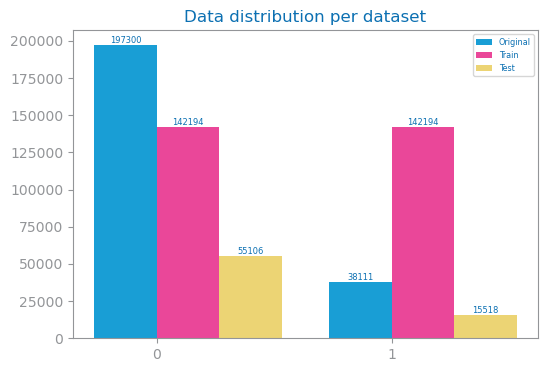

In [65]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(df[df[target] == 0]),  # Assuming 0 is the negative class
            len(df[df[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_3[train_3[target] == 0]),
        len(train_3[train_3[target] == 1]),
    ]
    values["Test"] = [
        len(test_3[test_3[target] == 0]),
        len(test_3[test_3[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

In [66]:
print("Train set class distribution:")
print(train_3[target].value_counts())

print("Test set class distribution:")
print(train_3[target].value_counts())

Train set class distribution:
is_purchase
0    142194
1    142194
Name: count, dtype: int64
Test set class distribution:
is_purchase
0    142194
1    142194
Name: count, dtype: int64


## Bal 3 evaluate

### eval target_metric_2 - precision

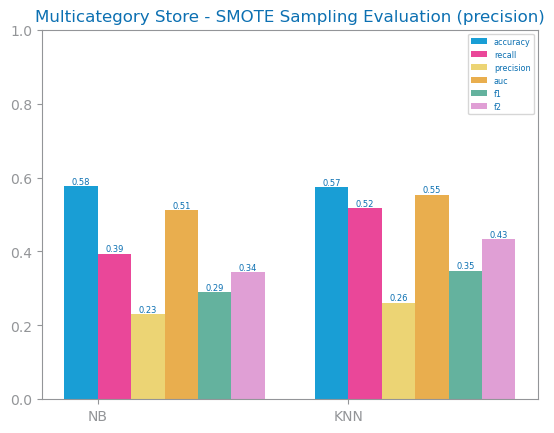

In [67]:
if evaluate == True:
    figure()
    eval_3: dict[str, list] = evaluate_approach(train_3, test_3, target='is_purchase', metric=target_metric_2)
    plot_multibar_chart(
        ["NB", "KNN"], eval_3, title=f"{file_tag} - SMOTE Sampling Evaluation ({target_metric_2})", percentage=True
    )
    savefig(f"images/{file_tag}_balancing_approach_3_eval_{target_metric_2}.png")
    show()

### eval target_metric - f2

In [68]:

def apply_strategy_3(df):

    # Create a copy of the dataframe
    df_copy = df.copy()

    df_smote=apply_balanced_smote(df_copy)


    return df_smote


train_3=apply_strategy_3(train)
test_3=test.copy()

Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

New class distribution:
is_purchase
0    50.0
1    50.0
Name: proportion, dtype: float64



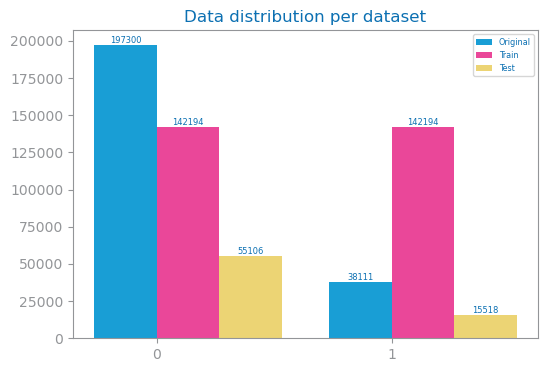

In [69]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(df[df[target] == 0]),  # Assuming 0 is the negative class
            len(df[df[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_3[train_3[target] == 0]),
        len(train_3[train_3[target] == 1]),
    ]
    values["Test"] = [
        len(test_3[test_3[target] == 0]),
        len(test_3[test_3[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

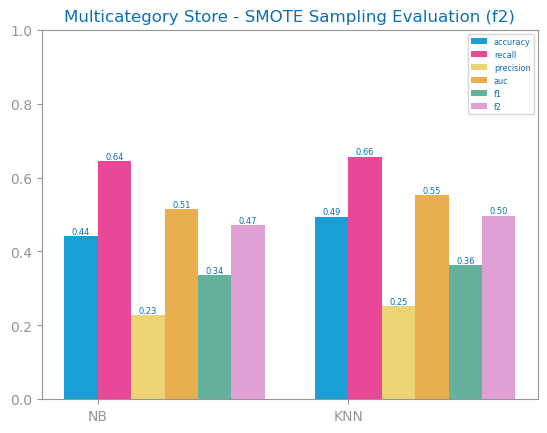

In [70]:
if evaluate == True:
    figure()
    eval_3: dict[str, list] = evaluate_approach(train_3, test_3, target='is_purchase', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_3, title=f"{file_tag} - SMOTE Sampling Evaluation ({target_metric})", percentage=True
    )
    savefig(f"images/{file_tag}_balancing_approach_3_eval_{target_metric}.png")
    show()

# Bal 2 - Hybrid

Reduce from negative class from 75 to 60% and then upsample the positives into 50/50


## Bal 2 strategy aplication

In [71]:
def apply_strategy_2(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    df_balanced=apply_balanced_hybrid(df_copy,target='is_purchase',minority_ratio=0.4)

    return df_balanced


train_2=apply_strategy_2(train)
test_2=test.copy()

Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

Hybrid class distribution (60.0/40.0):
is_purchase
0    60.000141
1    39.999859
Name: proportion, dtype: float64



In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235411 entries, 0 to 235410
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  235411 non-null  float64
 1   category_code_lvl_2  235411 non-null  float64
 2   price                235411 non-null  float64
 3   is_purchase          235411 non-null  int64  
 4   activity_in_session  235411 non-null  float64
 5   week_of_month        235411 non-null  int64  
 6   is_weekend           235411 non-null  int64  
 7   day                  235411 non-null  int64  
 8   brand_value          235411 non-null  float64
 9   product_category     235411 non-null  int64  
 10  time_of_day_sin      235411 non-null  float64
 11  time_of_day_cos      235411 non-null  float64
 12  day_of_week_sin      235411 non-null  float64
 13  day_of_week_cos      235411 non-null  float64
 14  hour_sin             235411 non-null  float64
 15  hour_cos             2

In [73]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 164447
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  142193 non-null  float64
 1   category_code_lvl_2  142193 non-null  float64
 2   price                142193 non-null  float64
 3   activity_in_session  142193 non-null  float64
 4   week_of_month        142193 non-null  float64
 5   is_weekend           142193 non-null  float64
 6   day                  142193 non-null  float64
 7   brand_value          142193 non-null  float64
 8   product_category     142193 non-null  float64
 9   time_of_day_sin      142193 non-null  float64
 10  time_of_day_cos      142193 non-null  float64
 11  day_of_week_sin      142193 non-null  float64
 12  day_of_week_cos      142193 non-null  float64
 13  hour_sin             142193 non-null  float64
 14  hour_cos             142193 non-null  float64
 15  min_sin              1

In [74]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70624 entries, 0 to 70623
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code_lvl_1  70624 non-null  float64
 1   category_code_lvl_2  70624 non-null  float64
 2   price                70624 non-null  float64
 3   activity_in_session  70624 non-null  float64
 4   week_of_month        70624 non-null  float64
 5   is_weekend           70624 non-null  float64
 6   day                  70624 non-null  float64
 7   brand_value          70624 non-null  float64
 8   product_category     70624 non-null  float64
 9   time_of_day_sin      70624 non-null  float64
 10  time_of_day_cos      70624 non-null  float64
 11  day_of_week_sin      70624 non-null  float64
 12  day_of_week_cos      70624 non-null  float64
 13  hour_sin             70624 non-null  float64
 14  hour_cos             70624 non-null  float64
 15  min_sin              70624 non-null  floa

## Bal 2 train/test split 

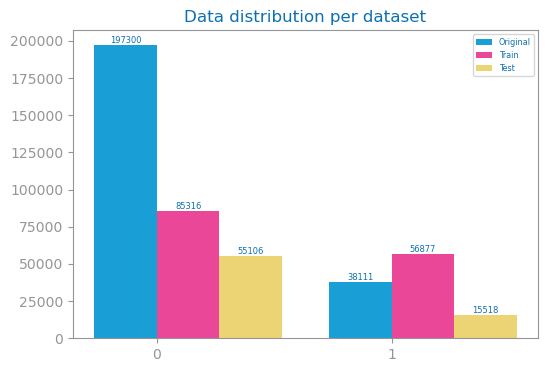

In [75]:
if evaluate==True:

    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(df[df[target] == 0]),  # Assuming 0 is the negative class
            len(df[df[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 2 evaluate

### eval target_metric_2 = precision

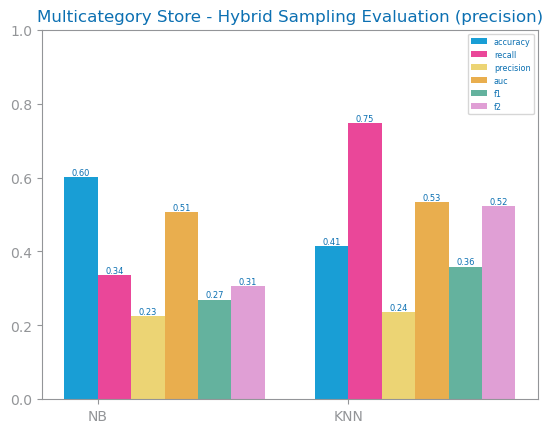

In [76]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric=target_metric_2)
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag} - Hybrid Sampling Evaluation ({target_metric_2})", percentage=True
    )
    savefig(f"images/{file_tag}_balacing_approach_2_eval_{target_metric_2}.png")
    show()

### eval target_metric = f2

In [77]:
def apply_strategy_2(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    df_balanced=apply_balanced_hybrid(df_copy,target='is_purchase',minority_ratio=0.4)

    return df_balanced


train_2=apply_strategy_2(train)
test_2=test.copy()

Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

Hybrid class distribution (60.0/40.0):
is_purchase
0    60.000141
1    39.999859
Name: proportion, dtype: float64



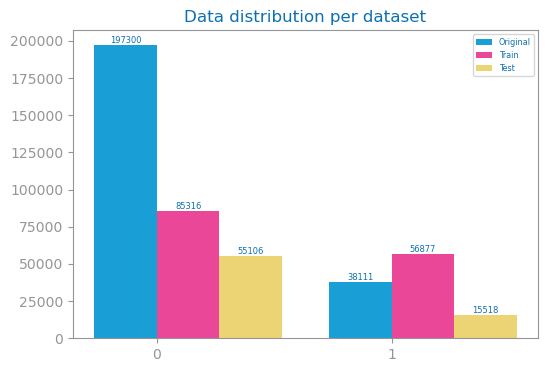

In [78]:
if evaluate==True:

    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(df[df[target] == 0]),  # Assuming 0 is the negative class
            len(df[df[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

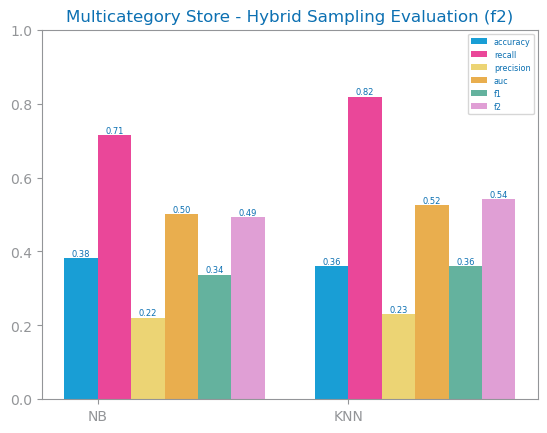

In [79]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric=target_metric)
    plot_multibar_chart(
         ["NB", "KNN"], eval_2, title=f"{file_tag} - Hybrid Sampling Evaluation ({target_metric})", percentage=True
    )
    savefig(f"images/{file_tag}_balacing_approach_2_eval_{target_metric}.png")
    show()

# Approach uplift comparison

## uplift df

In [80]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)
df_eval_3 = pd.DataFrame(eval_3, index=algorithms)

# Calculate uplift
# df_uplift = df_eval_2 - df_eval_1

# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_eval_3], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Undersampling', 'Hybrid', 'SMOTE'], eval_1.keys()])



# Display the DataFrame
comparison_df

Undersampling                                                    \
                 accuracy    recall precision       auc        f1        f2   
Naive Bayes      0.394837  0.722838  0.225899  0.512655  0.344222  0.501983   
KNN              0.455468  0.684947  0.240491  0.537897  0.355991  0.500099   

               Hybrid                                                    \
             accuracy    recall precision       auc        f1        f2   
Naive Bayes  0.382108  0.714332  0.220422  0.501442  0.336889  0.493272   
KNN          0.359354  0.819178  0.230494  0.524522  0.359762  0.542214   

                SMOTE                                                    
             accuracy    recall precision       auc        f1        f2  
Naive Bayes  0.440856  0.644026  0.227348  0.513834  0.336063  0.471277  
KNN          0.494506  0.656721  0.251233  0.552774  0.363432  0.496463

# Analysis

Compare eval balancing approaches:
- Approach 3 - SMOTE Sampling -  with better combination of precision and f2, so let's continue with that approach.

Comparing with previous dataset:
- Balanincg dataset Way Higher metrics for balancing, precision and recall way bigger, so let's move with SMOTE balancing dataset


Decision:
- For the rest of the evaluations, use balancing dataset

# save to csv

In [81]:

if test_data==False:
    
    # do not balance original dataset      
    data_save=df.copy()
               
    data_save.to_csv(f"dataset/df_ecom_2_6_bal_input.csv", index=False)

    # sampled versions to keep consistency    
    sample=0.09

    data_sample = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    data_sample.to_csv(f"dataset/df_ecom_2_6_bal_input_sample.csv", index=False)

    
    print(data_save.columns)



Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos'],
      dtype='object')


## train test csv

In [82]:
if test_data==False:

    # train_save,test_save=simple_split_df(data_save,sort_by='day_of_year')
    
    train_save=apply_strategy_3(train)         
    
    train_save.to_csv(f"dataset/df_ecom_2_6_bal_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_ecom_2_6_bal_input_test.csv", index=False)
    print(test.columns)



if test_data==False:
   
    train_save=apply_strategy_3(train)         
    train_save.to_csv(f"dataset/df_ecom_2_6_bal_input_train.csv", index=False)
 
    print(train.columns)

    test.to_csv(f"dataset/df_ecom_2_6_bal_input_test.csv", index=False)
    print(test.columns)

    
    # sampled versions to keep consistency    
    sample=0.09
    
    train_save_sample = train_save.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train_save_sample=apply_strategy_3(train_save_sample)         
    train_save_sample.to_csv(f"dataset/df_ecom_2_6_bal_input_train_sample.csv", index=False)

        
    test_save_sample = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test_save_sample.to_csv(f"dataset/df_ecom_2_6_bal_input_test_sample.csv", index=False)
    
    print(train_save.shape)
    print(train_save_sample.shape)
    print(test_save_sample.shape)

Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

New class distribution:
is_purchase
0    50.0
1    50.0
Name: proportion, dtype: float64

Index(['category_code_lvl_1', 'category_code_lvl_2', 'price',
       'activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos', 'is_purchase'],
      dtype='object')
Index(['category_code_lvl_1', 'category_code_lvl_2', 'price',
       'activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos', 'is_purchase'],
      dtype='object')
Original class distribution:
is_purchase
0    86.289574
1    13.710426
Name: proportion, dtype: float64

New clas